In [1]:
!pip install pandas_datareader

In [59]:
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.layers import Dropout, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf

### 데이터 수집

In [60]:
# 2005 ~ 2022까지의 데이터 불러오기
start = '2005-01-01'
end = '2022-01-01'

df = data.DataReader('AAPL.US', 'stooq', start, end)
df.to_csv('APPLE.csv') # csv 파일로 생성

In [61]:
df = pd.read_csv('APPLE.csv')
df

,Date,Open,High,Low,Close,Volume
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582
...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4280 non-null   object 
 1   Open    4280 non-null   float64
 2   High    4280 non-null   float64
 3   Low     4280 non-null   float64
 4   Close   4280 non-null   float64
 5   Volume  4280 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 200.8+ KB


### 데이터 전처리

In [63]:
# datetime 자료형으로 변경
df['Date'] = pd.to_datetime(df['Date'])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4280 non-null   datetime64[ns]
 1   Open    4280 non-null   float64       
 2   High    4280 non-null   float64       
 3   Low     4280 non-null   float64       
 4   Close   4280 non-null   float64       
 5   Volume  4280 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 200.8 KB


In [65]:
# 요일정보 추가 (월:0, 화:1, 수:2, 목:3, 금:4) - 주가는 평일에만 열리니까
df['weekday'] = df['Date'].dt.weekday
df

,Date,Open,High,Low,Close,Volume,weekday
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261,4
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014,3
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931,2
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339,1
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582,0
...,...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863,4
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454,3
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983,2
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965,1


In [66]:
# 시작 주로부터 몇 번째 주인지 궁금 (timedelta - 두 시간이나 날짜 차이 구하는 거)
start = datetime(2005, 1, 3)
df['weeks'] = (df['Date'] - start) // timedelta(weeks = 1)
df

,Date,Open,High,Low,Close,Volume,weekday,weeks
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261,4,886
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014,3,886
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931,2,886
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339,1,886
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582,0,886
...,...,...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863,4,0
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454,3,0
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983,2,0
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965,1,0


In [67]:
df = df[['Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close']]
df

,Date,weeks,weekday,High,Low,Open,Close
0,2021-12-31,886,4,179.2300,177.2600,178.0850,177.5700
1,2021-12-30,886,3,180.5700,178.0900,179.4700,178.2000
2,2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800
3,2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900
4,2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300
...,...,...,...,...,...,...,...
4275,2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601
4276,2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881
4277,2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875
4278,2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788


In [68]:
# 가장 오래된 날짜를 먼저 표시되도록 정렬
df.sort_values(by = 'Date', ascending = True, inplace = True)

C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [69]:
df

,Date,weeks,weekday,High,Low,Open,Close
4279,2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687
4278,2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788
4277,2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875
4276,2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881
4275,2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601
...,...,...,...,...,...,...,...
4,2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300
3,2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900
2,2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800
1,2021-12-30,886,3,180.5700,178.0900,179.4700,178.2000


In [70]:
# Date컬럼을 인덱스로 변경!
df.set_index(keys = 'Date', inplace = True)
df

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601
...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800


In [71]:
# 다음날의 종가와 당일의 종가의 차를 계산하여 새로운 컬럼으로 추가
df_shift = df.shift(-1) # 한 칸씩 당겨짐
df_shift

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,0.0,1.0,1.0023,0.9640,0.9760,0.9788
2005-01-04,0.0,2.0,0.9988,0.9788,0.9788,0.9875
2005-01-05,0.0,3.0,0.9935,0.9693,0.9921,0.9881
2005-01-06,0.0,4.0,1.0658,0.9916,0.9958,1.0601
2005-01-07,1.0,0.0,1.0825,1.0392,1.0701,1.0559
...,...,...,...,...,...,...
2021-12-27,886.0,1.0,181.3300,178.5300,180.1600,179.2900
2021-12-28,886.0,2.0,180.6300,178.1400,179.3300,179.3800
2021-12-29,886.0,3.0,180.5700,178.0900,179.4700,178.2000


In [72]:
df['Gap_close'] = df_shift['Close'] - df['Close']
df

C:\Users\user\AppData\Local\Temp/ipykernel_8768/3866158222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gap_close'] = df_shift['Close'] - df['Close']


,weeks,weekday,High,Low,Open,Close,Gap_close
Date,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,0.0101
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,0.0087
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,0.0006
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,0.0720
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,-0.0042
...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,-1.0400
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,0.0900
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,-1.1800


In [73]:
# 새로운 컬럼 Up을 추가하고, 다음날의 시작가가 올라가면:1, 내려가면:0
df.loc[df['Gap_close'] > 0, 'Up'] = 1
df.loc[df['Gap_close'] < 0, 'Up'] = 0

In [74]:
df

,weeks,weekday,High,Low,Open,Close,Gap_close,Up
Date,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,0.0101,1.0
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,0.0087,1.0
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,0.0006,1.0
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,0.0720,1.0
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,-0.0042,0.0
...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,-1.0400,0.0
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,0.0900,1.0
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,-1.1800,0.0


In [75]:
df.drop(['Gap_close'], axis = 1, inplace = True)

In [76]:
df

,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1.0
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1.0
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1.0
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1.0
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0.0
...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0.0
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1.0
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0.0


In [77]:
df['Up'].value_counts()

1.0    2272
0.0    1995
Name: Up, dtype: int64

<AxesSubplot:xlabel='Date'>

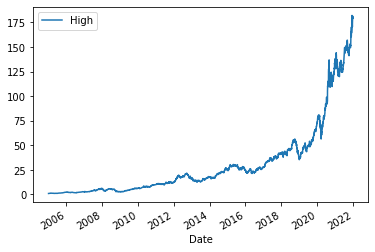

In [78]:
# High, Low, Open, Close -> line graph로 그려보기
df_new = df[['High']]
df_new.plot(kind = 'line')

<AxesSubplot:xlabel='Date'>

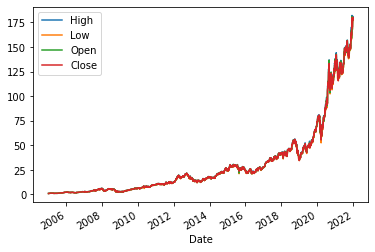

In [79]:
df_new = df[['High', 'Low', 'Open', 'Close']]
df_new.plot(kind = 'line')

In [80]:
df_shift = df.shift(1)
df_shift

,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,0.0,0.0,0.9967,0.9585,0.9930,0.9687,1.0
2005-01-05,0.0,1.0,1.0023,0.9640,0.9760,0.9788,1.0
2005-01-06,0.0,2.0,0.9988,0.9788,0.9788,0.9875,1.0
2005-01-07,0.0,3.0,0.9935,0.9693,0.9921,0.9881,1.0
...,...,...,...,...,...,...,...
2021-12-27,885.0,3.0,176.8499,175.2700,175.8500,176.2800,1.0
2021-12-28,886.0,0.0,180.4200,177.0700,177.0850,180.3300,0.0
2021-12-29,886.0,1.0,181.3300,178.5300,180.1600,179.2900,1.0


In [81]:
# 어느 정도 값이 증가했는지(비율)
df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1.0,NaN
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1.0,0.010426
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1.0,0.008888
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1.0,0.000608
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0.0,0.072867
...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0.0,0.022975
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1.0,-0.005767
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0.0,0.000502


In [82]:
# 시작가와 종가와의 차이
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1.0,NaN,0.0243
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1.0,0.010426,-0.0028
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1.0,0.008888,-0.0087
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1.0,0.000608,0.0040
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0.0,0.072867,-0.0643
...,...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0.0,0.022975,-3.2450
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1.0,-0.005767,0.8700
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0.0,0.000502,-0.0500


### 주가 예측을 위한 LSTM 모델 작성

In [83]:
# 몇 번째 주인지의 데이터를 list 형태로 저장.
list_weeks = []
list_weeks = df['weeks'].unique()
list_weeks

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [84]:
df[df['weeks'] == 0]

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1.0,NaN,0.0243
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1.0,0.010426,-0.0028
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1.0,0.008888,-0.0087
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1.0,0.000608,0.0040
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0.0,0.072867,-0.0643


In [85]:
# 각 주별로 일수가 몇일씩인지 확인 - weeks를 이용
df['week_days'] = 0
for i in list_weeks:
    df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])
    
df

C:\Users\user\AppData\Local\Temp/ipykernel_8768/2268003520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])


,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1.0,NaN,0.0243,5
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1.0,0.010426,-0.0028,5
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1.0,0.008888,-0.0087,5
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1.0,0.000608,0.0040,5
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0.0,0.072867,-0.0643,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0.0,0.022975,-3.2450,5
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1.0,-0.005767,0.8700,5
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0.0,0.000502,-0.0500,5


In [86]:
df[df['week_days'] < 4]

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2007-01-03,104,2,2.6512,2.5072,2.6420,2.5657,1.0,-0.012243,0.0763,3
2007-01-04,104,3,2.6320,2.5661,2.5775,2.6225,0.0,0.022138,-0.0450,3
2007-01-05,104,4,2.6392,2.5843,2.6283,2.6047,1.0,-0.006787,0.0236,3
2012-10-31,408,2,18.5110,18.0740,18.2940,18.3080,1.0,-0.014321,-0.0140,3
2012-11-01,408,3,18.5420,18.2720,18.3960,18.3430,0.0,0.001912,0.0530,3
2012-11-02,408,4,18.3560,17.6740,18.3250,17.7370,1.0,-0.033037,0.5880,3


In [87]:
# 평일 내내 데이터를 얻을 수 있는 날 - 3670개.(주 5일인 데이터만 추출)
df = df[df['week_days'] == 5]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1.0,NaN,0.0243,5
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1.0,0.010426,-0.0028,5
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1.0,0.008888,-0.0087,5
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1.0,0.000608,0.0040,5
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0.0,0.072867,-0.0643,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0.0,0.022975,-3.2450,5
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1.0,-0.005767,0.8700,5
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0.0,0.000502,-0.0500,5


In [88]:
df = df[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body', 'Up']]
df

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-01-03,0,0.9967,0.9585,0.9930,0.9687,NaN,0.0243,1.0
2005-01-04,1,1.0023,0.9640,0.9760,0.9788,0.010426,-0.0028,1.0
2005-01-05,2,0.9988,0.9788,0.9788,0.9875,0.008888,-0.0087,1.0
2005-01-06,3,0.9935,0.9693,0.9921,0.9881,0.000608,0.0040,1.0
2005-01-07,4,1.0658,0.9916,0.9958,1.0601,0.072867,-0.0643,0.0
...,...,...,...,...,...,...,...,...
2021-12-27,0,180.4200,177.0700,177.0850,180.3300,0.022975,-3.2450,0.0
2021-12-28,1,181.3300,178.5300,180.1600,179.2900,-0.005767,0.8700,1.0
2021-12-29,2,180.6300,178.1400,179.3300,179.3800,0.000502,-0.0500,0.0


### 학습 데이터와 검증 데이터 분리

In [89]:
from sklearn.model_selection import train_test_split

In [90]:
# 학습 데이터 (2005 ~ 2019) -> df_train
# 검증 데이터 (2020 ~ 2021) -> df_test
df_train = df['2005-02-01' : '2019-12-31'] # 처음 시작 값이 nan값이어서 에러났음.
df_train

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-02-01,1,1.1906,1.1724,1.1795,1.1872,0.008409,-0.0077,1.0
2005-02-02,2,1.2233,1.1893,1.1941,1.2190,0.026786,-0.0249,0.0
2005-02-03,3,1.2163,1.1838,1.2131,1.1914,-0.022642,0.0217,1.0
2005-02-04,4,1.2085,1.1872,1.1941,1.2070,0.013094,-0.0129,1.0
2005-02-07,0,1.2147,1.1864,1.2095,1.2085,0.001243,0.0010,1.0
...,...,...,...,...,...,...,...,...
2019-12-16,0,69.1710,68.2300,68.2340,68.9430,0.017128,-0.7090,1.0
2019-12-17,1,69.4130,68.6800,68.8710,69.0750,0.001915,-0.2040,0.0
2019-12-18,2,69.4440,68.7600,68.9280,68.9140,-0.002331,0.0140,1.0


In [91]:
df_test = df['2020-01-01' : ]
df_test

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2020-01-06,0,73.891,72.119,72.369,73.851,0.007916,-1.482,0.0
2020-01-07,1,74.125,73.283,73.861,73.508,-0.004644,0.353,1.0
2020-01-08,2,74.995,73.201,73.203,74.688,0.016053,-1.485,1.0
2020-01-09,3,76.467,75.432,75.684,76.278,0.021289,-0.594,1.0
2020-01-10,4,77.023,75.935,76.510,76.445,0.002189,0.065,1.0
...,...,...,...,...,...,...,...,...
2021-12-27,0,180.420,177.070,177.085,180.330,0.022975,-3.245,0.0
2021-12-28,1,181.330,178.530,180.160,179.290,-0.005767,0.870,1.0
2021-12-29,2,180.630,178.140,179.330,179.380,0.000502,-0.050,0.0


In [92]:
# Up를 제외한 나머지 컬럼은 학습데이터로 사용 / Up 컬럼은 정답데이터로 사용
X_train = df_train[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_train = df_train['Up'] # 종속변수

print(X_train)
print(y_train)

            weekday     High      Low     Open    Close  Close_ratio    Body
Date                                                                        
2005-02-01        1   1.1906   1.1724   1.1795   1.1872     0.008409 -0.0077
2005-02-02        2   1.2233   1.1893   1.1941   1.2190     0.026786 -0.0249
2005-02-03        3   1.2163   1.1838   1.2131   1.1914    -0.022642  0.0217
2005-02-04        4   1.2085   1.1872   1.1941   1.2070     0.013094 -0.0129
2005-02-07        0   1.2147   1.1864   1.2095   1.2085     0.001243  0.0010
...             ...      ...      ...      ...      ...          ...     ...
2019-12-16        0  69.1710  68.2300  68.2340  68.9430     0.017128 -0.7090
2019-12-17        1  69.4130  68.6800  68.8710  69.0750     0.001915 -0.2040
2019-12-18        2  69.4440  68.7600  68.9280  68.9140    -0.002331  0.0140
2019-12-19        3  69.2650  68.7180  68.8550  68.9810     0.000972 -0.1260
2019-12-20        4  69.6270  68.6200  69.5240  68.8400    -0.002044  0.6840

In [93]:
# Up를 제외한 나머지 컬럼은 학습데이터로 사용 / Up 컬럼은 정답데이터로 사용
X_test = df_test[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_test = df_test['Up'] # 종속변수

print(X_test)
print(y_test)

            weekday     High      Low     Open    Close  Close_ratio   Body
Date                                                                       
2020-01-06        0   73.891   72.119   72.369   73.851     0.007916 -1.482
2020-01-07        1   74.125   73.283   73.861   73.508    -0.004644  0.353
2020-01-08        2   74.995   73.201   73.203   74.688     0.016053 -1.485
2020-01-09        3   76.467   75.432   75.684   76.278     0.021289 -0.594
2020-01-10        4   77.023   75.935   76.510   76.445     0.002189  0.065
...             ...      ...      ...      ...      ...          ...    ...
2021-12-27        0  180.420  177.070  177.085  180.330     0.022975 -3.245
2021-12-28        1  181.330  178.530  180.160  179.290    -0.005767  0.870
2021-12-29        2  180.630  178.140  179.330  179.380     0.000502 -0.050
2021-12-30        3  180.570  178.090  179.470  178.200    -0.006578  1.270
2021-12-31        4  179.230  177.260  178.085  177.570    -0.003535  0.515

[435 rows x

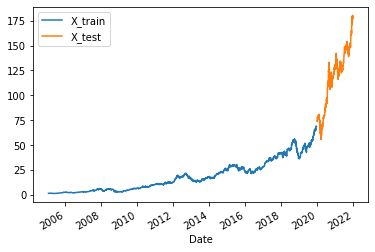

<Figure size 1440x1080 with 0 Axes>

In [94]:
X_train['Close'].plot(kind = 'line')
X_test['Close'].plot(kind = 'line')

plt.legend(['X_train', 'X_test'])
plt.figure(figsize = (20, 15))
plt.show()

In [95]:
# 정확도가 낮다면?
# data set를 바꾸기(데이터 증강)
# 하이퍼 파라미터 조정
# 알고리즘 변경

In [96]:
# sequences data로 만들기 (월, 화, 수, 목(4일씩) -> 하나로.)
# - 금요일 데이터 분석!
# 학습 데이터(sequences data), 정답 데이터 -> 월 ~ 목까지 1 set
# LSTM -> Numpy 배열
# StandardScaler 사용
def Scaler_to_np(df):
    df_list = []
    df = np.array(df)
    for i in range(0, len(df) - 3, 4): # 5
        df_s = df[i : i + 4]
        scaler = StandardScaler()
        df_scaler = scaler.fit_transform(df_s)
        df_list.append(df_scaler)
    
    return np.array(df_list) # 차원을 3차원으로 만듦.(왜냐 모델에 넣을거니까)

In [40]:
for i in range(0, 50, 5):
    print(i)
return

0
5
10
15
20
25
30
35
40
45


SyntaxError: 'return' outside function (Temp/ipykernel_8768/3875199008.py, line 3)

In [97]:
X_train_array = Scaler_to_np(X_train)
X_test_array = Scaler_to_np(X_test)

# 3차원 배열
print(X_train_array.shape)
print(X_test_array.shape)

(804, 4, 7)
(108, 4, 7)


In [98]:
print(X_train_array)

[[[-1.34164079 -1.56430318 -1.65180177 ... -1.10068807  0.11045772
   -0.10210593]
  [-0.4472136   1.11735941  0.93895924 ...  1.40840731  1.12675446
   -1.10566134]
  [ 0.4472136   0.5433032   0.09581217 ... -0.76929811 -1.60675499
    1.61327367]
  [ 1.34164079 -0.09635944  0.61703036 ...  0.46157887  0.3695428
   -0.4055064 ]]

 [[-1.34164079 -0.95678059 -0.34365952 ... -0.30080767  0.1411124
   -0.15842974]
  [-0.4472136   0.73213338  1.31253094 ...  1.69349731  1.42607415
   -1.3598553 ]
  [ 0.4472136   1.23555965  0.43475    ... -0.50688585 -1.38291079
    1.45667347]
  [ 1.34164079 -1.01091244 -1.40362142 ... -0.88580379 -0.18427577
    0.06161157]]

 [[ 1.52127766 -1.39206542 -1.40153153 ... -1.41636119  0.05650949
    1.58068239]
  [-1.18321596 -0.48915632 -0.46323475 ... -0.42358465  0.66635006
   -0.68725321]
  [-0.50709255  0.77723652  0.72934834 ...  0.67319704  0.92144227
    0.1145422 ]
  [ 0.16903085  1.10398521  1.13541795 ...  1.1667488  -1.64430181
   -1.00797138]]



In [99]:
print(y_train)

Date
2005-02-01    1.0
2005-02-02    0.0
2005-02-03    1.0
2005-02-04    1.0
2005-02-07    1.0
             ... 
2019-12-16    1.0
2019-12-17    0.0
2019-12-18    1.0
2019-12-19    0.0
2019-12-20    1.0
Name: Up, Length: 3219, dtype: float64


In [100]:
print(y_test)

Date
2020-01-06    0.0
2020-01-07    1.0
2020-01-08    1.0
2020-01-09    1.0
2020-01-10    1.0
             ... 
2021-12-27    0.0
2021-12-28    1.0
2021-12-29    0.0
2021-12-30    0.0
2021-12-31    NaN
Name: Up, Length: 435, dtype: float64


In [45]:
a=[0,1,2,3,4,5,6,7,8,9,10,11,12]
a[4::5]

[4, 9]

In [46]:
a[3:]

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [101]:
# 금요일만 가져오기
y_train_new = y_train[3::4] # 4개씩 데이터 끊어주기 4, 5
y_test_new = y_test[3::4]
print(len(y_train_new))
print(len(y_test_new))

804
108


In [57]:
y_train_new.value_counts()

1.0    344
0.0    299
Name: Up, dtype: int64

In [52]:
df.shape

(3670, 8)

### LSTM 모델 생성

In [102]:
# batch_input_shape(batch_size, sequence(time_steps), 입력 수(features))
def gen_lstm_compile(df):
    model = Sequential()
    # batch - 일괄 처리되는 작업의 양
    model.add(LSTM(256, activation = 'relu',
                   batch_input_shape = (None, df.shape[1], df.shape[2]))) 
    model.add(Dropout(0.2)) # 과대적합을 막기 위해
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [103]:
# 시계열 데이터 모델 검증하기 - 교차검증 (Timeseries Validation -> TimeSeriesSplit)
# 그룹의 최적화된 파라미터를 사용하겠다.
valid_scores = [] # 4번의 교차검증의 결과 저장
tscv = TimeSeriesSplit(n_splits = 4)

In [104]:
# enumerate() - 인덱스와 원소로 이루어진 튜플을 만들어줌.
# 인자로 넘어온 목록을 기준으로 인덱스와 원소를 차례대로 접근하게 해주는 반복자(iterator) 
# 훈련 & 검증 - 훈련 다음 데이터가 검증 데이터.(검증 데이터는 랜덤 or not)
for fold, (train_indices, value_indices) in enumerate(tscv.split(X_train_array)):
    X_train, X_valid = X_train_array[train_indices], X_train_array[value_indices]
    y_train, y_valid = y_train_new[train_indices], y_train_new[value_indices]
    
    model = gen_lstm_compile(X_train)
    model.fit(X_train, y_train, epochs = 10, batch_size = 64)
    
    y_pred = model.predict(X_valid)
    
    y_pred = np.where(y_pred < 0.5, 0, 1)
    
    # accuracy_score - 정답배열과 예측값의 배열을 넣으면 정확도가 평가됨.
    score = accuracy_score(y_valid, y_pred)
    print(f'fold: {fold} score: {score}')
    
    valid_scores.append(score)

Epoch 1/10
3/3 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.5427
Epoch 2/10
3/3 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.4695
Epoch 3/10
3/3 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.4695
Epoch 4/10
3/3 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4695
Epoch 5/10
3/3 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4695
Epoch 6/10
3/3 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4695
Epoch 7/10
3/3 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4695
Epoch 8/10
3/3 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4695
Epoch 9/10
3/3 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4695
Epoch 10/10
3/3 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4695
fold: 0 score: 0.6
Epoch 1/10
6/6 [==============================]

In [105]:
print(f'valid_scores: {valid_scores}')
cv_score = np.mean(valid_scores)
print(f'cv_score: {cv_score}')

valid_scores: [0.6, 0.475, 0.51875, 0.5625]
cv_score: 0.5390625


In [106]:
# 훈련 데이터를 모델에 집어넣음.
model = gen_lstm_compile(X_train_array)
r = model.fit(X_train_array, y_train_new, epochs = 10, batch_size = 64)

Epoch 1/10
13/13 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.4950
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4627
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4627
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4627
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4627
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4627
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4627
Epoch 8/10
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4627
Epoch 9/10
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4627
Epoch 10/10
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4627


In [107]:
# 예측
pred = model.predict(X_test_array)
pred[:10]

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

In [108]:
pred = np.where(pred < 0.5, 0, 1)
pred[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [109]:
print(f'accuracy= {accuracy_score(y_true = y_test_new, y_pred = pred)}')

accuracy= 0.5555555555555556


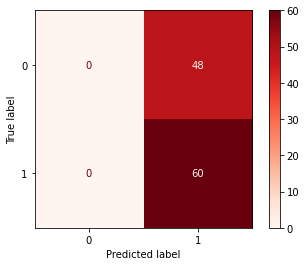

In [110]:
cm = confusion_matrix(y_test_new, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap = plt.cm.Reds)

In [ ]:
# 과제 - 주가 종목 선택 후 2005-01-01 ~ 2022-02-28(학습, 검증 데이터)까지 
# 데이터 분석/예측 후, 상승/하락 예측
# 2022-03-01 ~ 2022-03-18(테스트 데이터) 이후 데이터 정확도 확인